Step 1: Load Dataset

In [58]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Step 2: Drop Non-Numeric Columns

In [59]:
df_numeric = df.select_dtypes(include=['number'])

Step 3: Scatter Plots vs GDPP

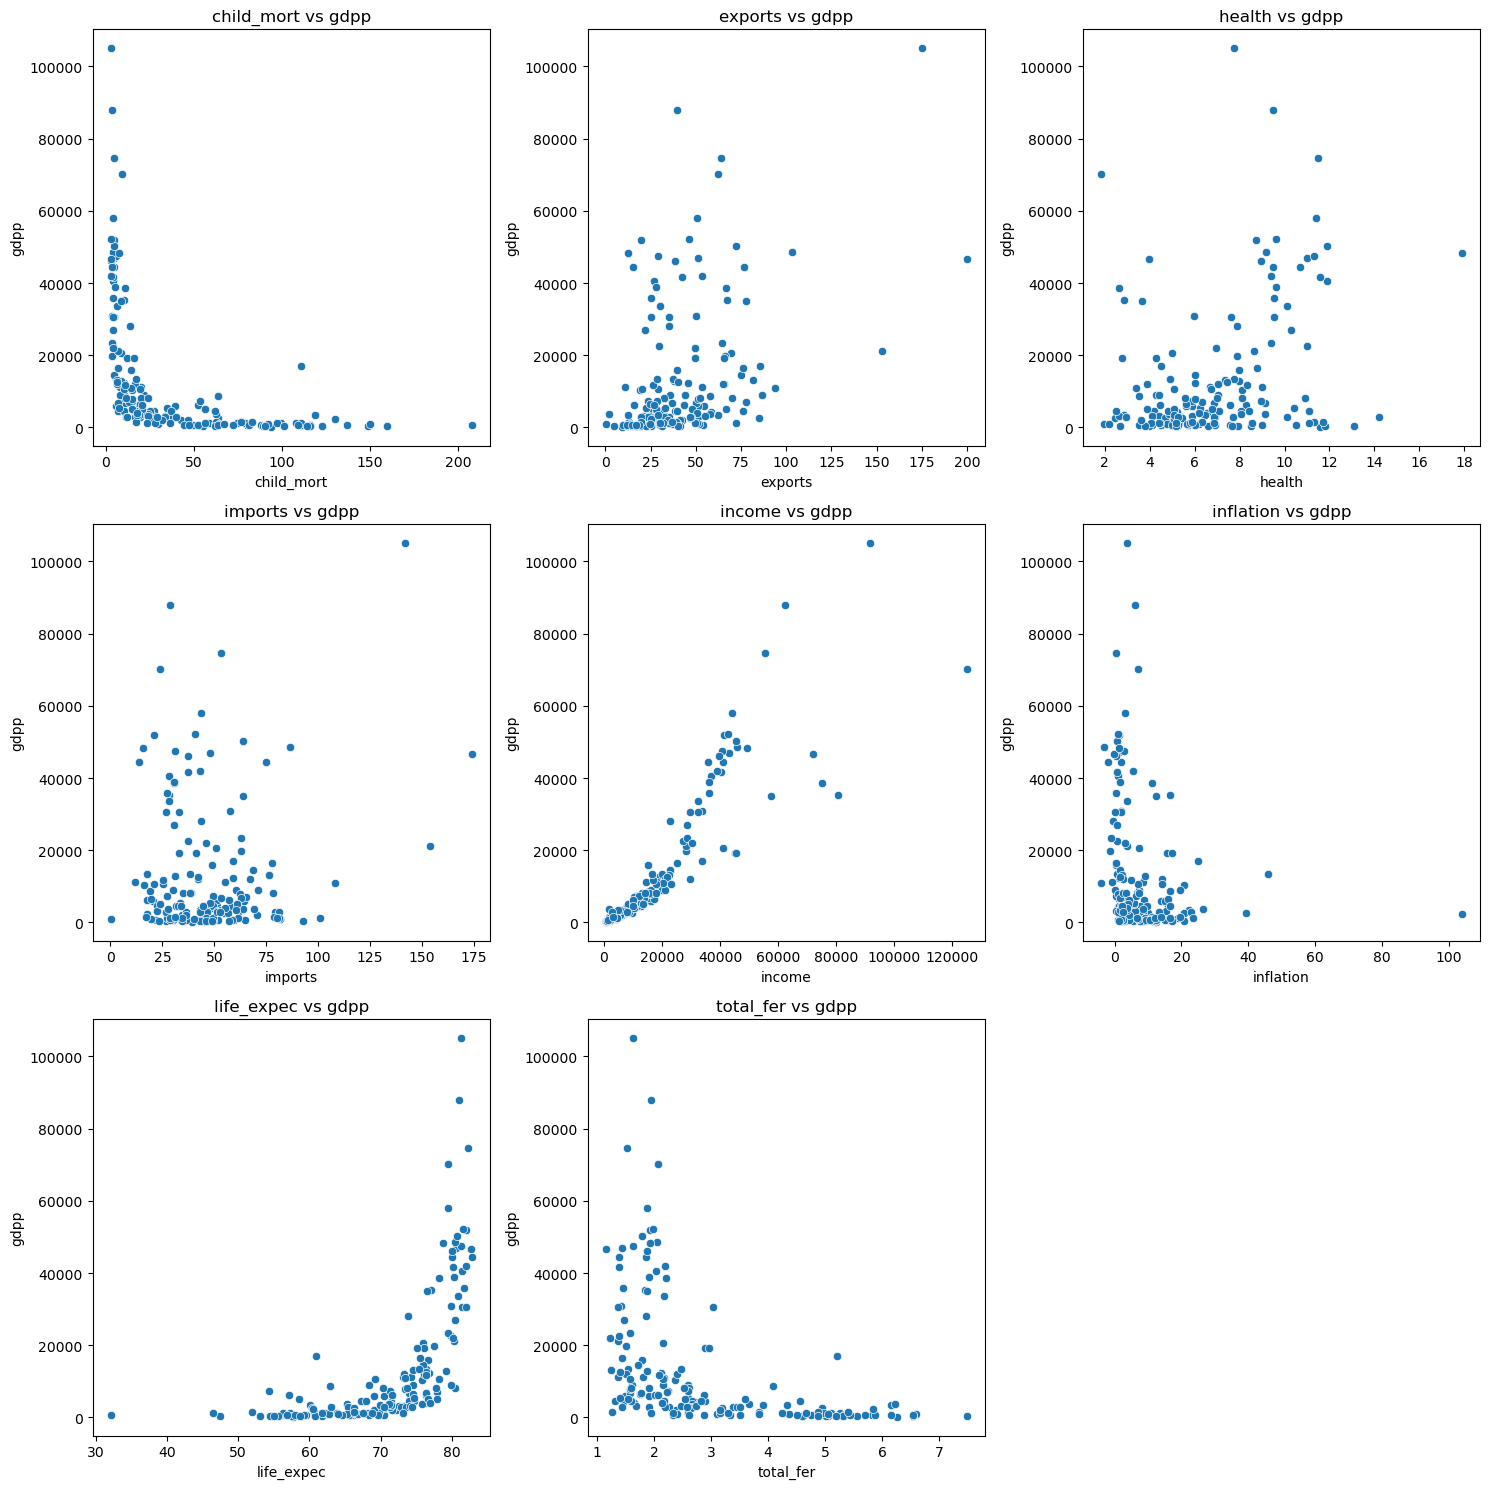

In [60]:
variables = [col for col in df_numeric.columns if col != "gdpp"]

plt.figure(figsize=(15, 15))
for i, var in enumerate(variables):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=df_numeric[var], y=df_numeric["gdpp"])
    plt.title(f'{var} vs gdpp')
plt.tight_layout()
plt.show()

# Most Separable
Child_mort vs GDPP
- Clear inverse relationship
Points seem to form distinct density bands:
- High child mortality + low GDPP
- Mid-range cluster
- Low child mortality + high GDPP

In [61]:
df_numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


These severe outliers can:
- Overload memory during scaling
- Compress most values into near-zero
- Cause poor clustering and kernel crashes

Step 4: Normalise Dataset
Solution: Cap the Outliers

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)


Step 5: Find optimal number of clusters
Elbow Method and Silhouette Score:

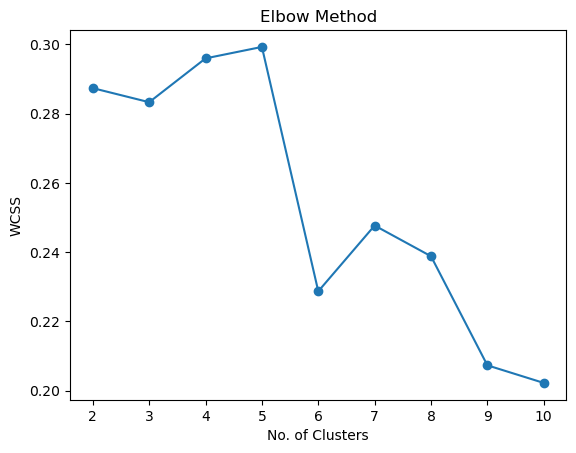

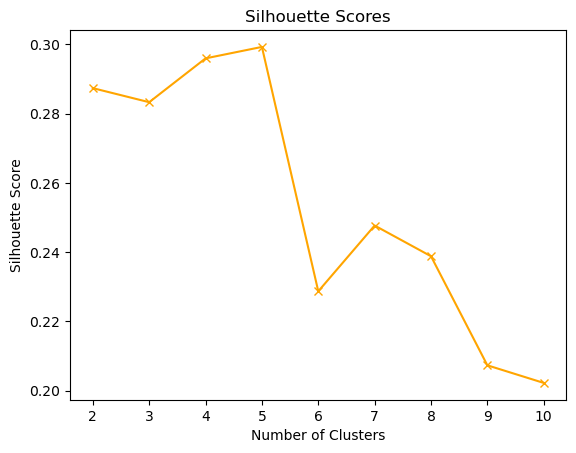

In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
sil_score = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
    sil_score.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot Elbow
plt.plot(range(2, 11), sil_score, marker='o')
plt.title("Elbow Method")
plt.xlabel("No. of Clusters")
plt.ylabel("WCSS")
plt.show()

# Plot Silhouette Scores
plt.figure()
plt.plot(range(2, 11), sil_score, marker='x', color='orange')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

Step 6: Fit Optimal KMeans
Assume optimal clusters = 3 (you'll confirm from above)

In [64]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(df_scaled)

silhouette = silhouette_score(df_scaled, labels)

Step 7: Visualise Clusters

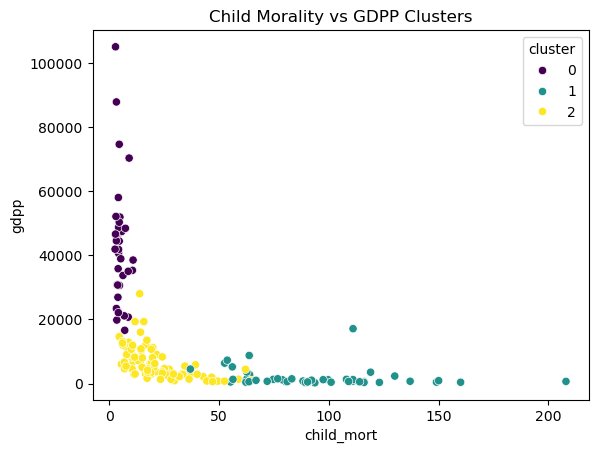

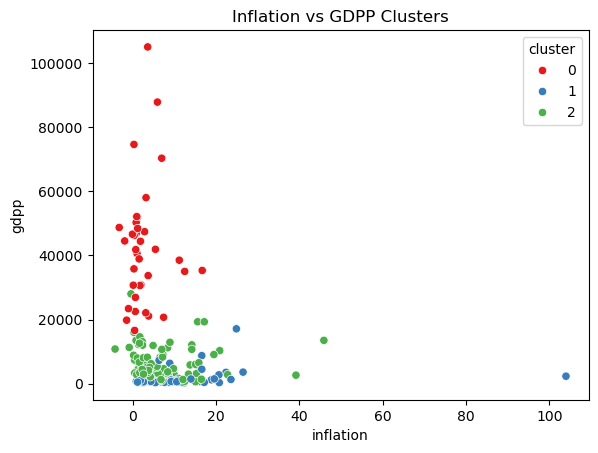

In [65]:
import numpy as np

df_clustered = df_numeric.copy()
df_clustered['cluster'] = labels

# Plot 1: Child Mortality vs GDPP
sns.scatterplot(data=df_clustered, x='child_mort', y='gdpp', hue='cluster', palette='viridis')
plt.title("Child Morality vs GDPP Clusters")
plt.show()

# Plot 2: Inflation vs GDPP
sns.scatterplot(data=df_clustered, x='inflation', y='gdpp', hue='cluster', palette='Set1')
plt.title("Inflation vs GDPP Clusters")
plt.show()

Step 8: Label and Justify Clusters
Add label based on known development indicators:

In [66]:
# Based on gdpp and child_morality range per cluster
cluster_summary = df_clustered.groupby('cluster')[["gdpp", "child_mort", "inflation"]].mean()
print(cluster_summary)

# Assign descriptive labels
def label_development(row):
    if row["cluster"] == 0:
        return "Least Developed"
    elif row["cluster"] == 1:
        return "Developing"
    else:
        return "Developed"
    
df_clustered["development_status"] = df_clustered.apply(label_development, axis=1)

                 gdpp  child_mort  inflation
cluster                                     
0        42494.444444    5.000000   2.671250
1         1922.382979   92.961702  12.019681
2         6486.452381   21.927381   7.600905
